In [1]:
import numpy as np
import random
import itertools
from numpy.linalg import matrix_rank
from numpy import linalg as LA
from numpy.linalg import inv
import plotly.express as px
from scipy.sparse.linalg import svds
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.spatial.distance import squareform
# from ripser import ripser
from persim import plot_diagrams
from mpl_toolkits import mplot3d
from scipy.stats import random_correlation
from tqdm import tqdm
from scipy.stats import sem
%matplotlib inline

random.seed(22)

/home/ag16115/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


$Y = X + \sigma E, \ \ \ \ \ \ \max_{i = 1, \dots, n} \|p^{-1/2} Q \zeta_i - \phi(Z_i) \|_2 \leq \epsilon \\$
$p^{-1/2}[\zeta_1| \dots | \zeta_n]^\top = p^{-1/2} Y V_Y = U_Y \Lambda _Y ^{1/2} $


# functions

In [2]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

both take in Y, not YYT

In [3]:
def pc_scores(X, r):
    U, s, Vh = svds(X,k=r)
    idx = s.argsort()[::-1]   
    Vh = Vh[idx,:]
    Y = X @ Vh.T
    return Y

In [4]:
def embed(X, r):
    U, s, Vh = svds(X,k=r)
    idx = s.argsort()[::-1]   
    U = U[:,idx]
    s = s[idx]
    Y = U @ np.diag(s)
    return Y

In [5]:
def embed_cov(X, r):
    U, s, Vh = svds(X,k=r)
    idx = s.argsort()[::-1]   
    U = U[:,idx]
    s = s[idx]
    Y = U @ np.diag(np.sqrt(s))
    return Y

In [6]:
def full_embed(X):
    U, s, Vh = np.linalg.svd(X, full_matrices=True)
    idx = s.argsort()[::-1]   
    U = U[:,idx]
    s = s[idx]
    Vh = Vh[idx,:]
    Y = U @ np.diag(np.sqrt(s))
    return Y 

In [7]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

# mixture model 

## varying n and p

In [8]:
r = 3
Z = np.array(range(0,r))+1
# es = np.random.rand(r)
# gaus = random_correlation.rvs(r * es / np.sum(es))
gaus = np.array([[ 1.        , -0.6248412 ,  0.17418772],
       [-0.6248412 ,  1.        , -0.3262174 ],
       [ 0.17418772, -0.3262174 ,  1.        ]])
centers = full_embed(gaus)
sigma = 1

### fix p, vary n

In [9]:
ns = [100, 200, 500, 1000]
p = 200
r = 3

phis = []
zetas = []
for n in ns:
    zs = np.array(random.choices(Z, k=n))
    X = np.random.multivariate_normal(np.zeros(r),gaus,size=p).T[zs-1]
    Y = X + sigma * np.random.normal(0,1,X.shape)
    phi = centers[(zs-1)]

    zeta = pc_scores(p**-.5 * Y,r)


    R, sca = orthogonal_procrustes(zeta, phi)
    zeta = zeta @ R
    
    phis.append(phi)
    zetas.append(zeta)

In [10]:
ns_df = []
for i in range(len(ns)):
    df = pd.DataFrame(np.vstack((zetas[i],phis[i])),columns = ['x','y','z'])
    df['n'] = np.repeat(ns[i],2*ns[i])
    df['type'] = np.repeat(['steelblue2','firebrick'],ns[i])
    ns_df.append(df)
ns_df = pd.concat(ns_df)
ns_df.to_csv('ns_df_p200.csv',index=False)

### fix n, vary p

In [11]:
ps = [100, 500, 1000, 10000]
n = 200
r = 3

phis = []
zetas = []

for p in ps:
    zs = np.array(random.choices(Z, k=n))
    X = np.random.multivariate_normal(np.zeros(r),gaus,size=p).T[zs-1]
    Y = X + sigma * np.random.normal(0,1,X.shape)
    phi = centers[(zs-1)]

    zeta = pc_scores(p**-.5 * Y,r)

    R, sca = orthogonal_procrustes(zeta, phi)
    zeta = zeta @ R
    
    phis.append(phi)
    zetas.append(zeta)

In [12]:
ps_df = []
for i in range(len(ps)):
    df = pd.DataFrame(np.vstack((zetas[i],phis[i])),columns = ['x','y','z'])
    df['p'] = np.repeat(ps[i],2*n)
    df['type'] = np.repeat(['steelblue2','firebrick'],n)
    ps_df.append(df)
ps_df = pd.concat(ps_df)
ps_df.to_csv('ps_df_n200.csv',index=False)

## errors

In [13]:
r = 3
Z = np.array(range(0,r))+1
# es = np.random.rand(r)
# gaus = random_correlation.rvs(r * es / np.sum(es))
gaus = np.array([[ 1.        , -0.6248412 ,  0.17418772],
                   [-0.6248412 ,  1.        , -0.3262174 ],
                   [ 0.17418772, -0.3262174 ,  1.        ]])
centers = full_embed(gaus)
sigma = 1

In [14]:
# cov = gaus[tuple(np.meshgrid(zs-1,zs-1))]

In [15]:
n_sim = 1

In [16]:
## used to find errors that are loaded below
# %%time

# ns = list(range(10, 100, 20)) + list(range(100, 200, 50)) + list(range(200, 1000, 400)) + list(range(1000, 11000, 1000))
# ps = [200,1000,10000,15000] 

# Ps = []
# Ns = []
# df = pd.DataFrame(columns = ['n','p','error_max'])
# r = 3
# max_errors = []
# sum_errors = []

# for p in ps:
#     print(ps.index(p)) 
#     for n in tqdm(ns):
#         Ps.append(p)
#         Ns.append(n)
#         errors_max = []
#         errors_sum = []
#         for i in range(0,n_sim):
#             zs = np.array(random.choices(Z, k=n))
#             X = np.random.multivariate_normal(np.zeros(r),gaus,size=p).T[zs-1]
#             Y = X + sigma * np.random.normal(0,1,X.shape)
            
#             phi = centers[(zs-1)]
            
#             zeta = pc_scores(p**-.5 * Y,r)
            
#             errors_max.append(np.max(np.abs(pdist(zeta, metric='euclidean') - pdist(phi, metric='euclidean'))))
#             errors_sum.append((2/(n*(n-1)))*np.sum(np.abs(pdist(zeta, metric='euclidean') - pdist(phi, metric='euclidean'))))
#         max_errors.append(np.mean(errors_max))
#         sum_errors.append(np.mean(errors_sum))
#         new_row = {'n': n, 'p': p , 'error_max':np.mean(errors_max), 'error_average':np.mean(errors_sum), 'se_max': sem(errors_max), 'se_average': sem(errors_sum)}
#         df = pd.concat([df,pd.DataFrame(new_row, index=[0])]).reset_index(drop=True)

In [17]:
# df.to_csv('r3_df.csv',index=False)

In [18]:
df = pd.read_csv('r3_df.csv')

In [19]:
MEs = np.loadtxt('r3_mean_errors.txt')
AEs = np.loadtxt('r3_average_errors.txt')
Ps = np.loadtxt('Ps.txt')
Ns = np.loadtxt('Ns.txt')

In [20]:
r_ns = list(range(10, 100, 10)) + list(range(100, 200, 60)) + list(range(200, 1000, 400)) + list(range(1000, 6000, 1000))
df = df[df['n'].isin(r_ns)]

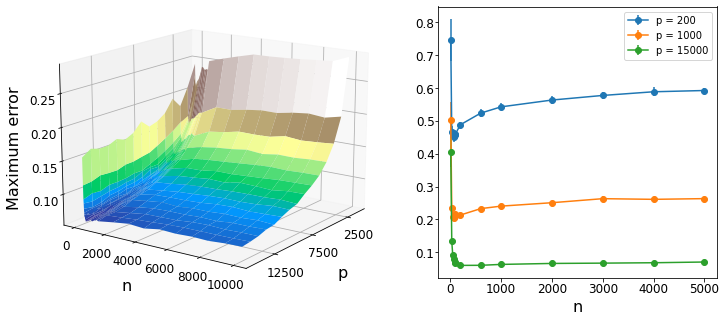

In [21]:
n1 = 1
n2 = Ns.shape[1]
p1 = 4
p2 = Ps.shape[1]


fig,axes = plt.subplots(1,2,figsize = (15,5),gridspec_kw={'width_ratios': [2, 1]})
ax = axes.flat

r_ps = [200,1000,15000] 
for p in r_ps:
    ax[1].errorbar(df[df['p'] == p]['n'],df[df['p'] == p]['error_max'], yerr=2*df[df['p'] == p]['se_max'],label=f'p = {p}', fmt='-o')
ax[1].legend(loc="upper right", bbox_to_anchor=(1, 1))
# ax[1].set_title('Maximum error')
ax[1].set_xlabel('n',fontsize = 16)
ax[1].tick_params(axis='x', labelsize=12,pad=0)
ax[1].tick_params(axis='y', labelsize=12,pad=0)


ax[0].remove()
ax[0] = fig.add_subplot(121,projection='3d')

ax[0].plot_surface(Ps[p1:p2,n1:n2], Ns[p1:p2,n1:n2], MEs[p1:p2,n1:n2], cmap='terrain')
ax[0].set_xlabel('p',fontsize = 16)
ax[0].set_ylabel('n',fontsize = 16)
ax[0].zaxis.set_rotate_label(False) 
ax[0].set_zlabel('Maximum error',rotation=90,fontsize = 16, labelpad=0);
ax[0].view_init(15, 35)
ax[0].dist = 8

ticks = np.arange(2500, 15000, 5000)
ax[0].set_xticks(ticks)
ax[0].tick_params(axis='x', labelsize=12,pad=0)
ax[0].tick_params(axis='y', labelsize=12,pad=0)
ax[0].tick_params(axis='z', labelsize=12,pad=0)


fig.subplots_adjust(hspace=0,wspace=0)
box = ax[1].get_position()
box.x0 = box.x0 - .05
box.x1 = box.x1 - .05
ax[1].set_position(box)
# fig.savefig(f"mixture_example.pdf", bbox_inches='tight')